# control estimation of attraction in the presence of diffusion
Tim Tyree<br>
11.2.2021

In [17]:
import cupy as cp, numpy as np
import time
import matplotlib.pyplot as plt
from lib import *

In [2]:
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
seed=42
# #random number stream A
# rs = RandomState(MT19937(SeedSequence(seed)))
# #random number stream B
# # rs = RandomState(MT19937(SeedSequence(987654321)))
np.random.seed(seed)
cp.random.seed(seed)

# single simulation of diffusion in an unbounded domain
- TODO: grid search over D from 0.1 to 2 in steps of 0.1
- (GPU accelerate in cupy)
- TODO: rewrite it from scratch, developing in vectorized pairs of particles
- start 2 particles 1/np.sqrt(2) away from one another

__Schema__
1. t,x1,x2,y1,y2,pair_num

In [4]:
num_pairs=1500 #number of independent pairs of particles
a=2 #cm^2/s known attraction coefficient 
D=1 #cm^2/s known diffusion coefficient
Dt=1e-5
print_every=100000

In [5]:
#initialize particles locations as being at the same location for
t=0
x1=0
x2=0.5
y1=0
y2=0.5
zero_values=np.zeros(num_pairs)

In [6]:
x1_values=zero_values.copy()+x1
x2_values=zero_values.copy()+x2
y1_values=zero_values.copy()+y1
y2_values=zero_values.copy()+y2

In [7]:
stepscale = np.sqrt(2 * D * Dt)
impulse_prefactor = a * Dt

In [8]:
tmax=10#0.1#1 #seconds
num_steps=np.int(np.around(tmax/Dt))

position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
mean_array=np.zeros(shape=(num_steps,3))
std_array=np.zeros(shape=(num_steps,3))
num_steps

1000000

In [9]:
#GOAL: add support for still_running
rend=0.001 #cm
boo_still_running=zero_values==zero_values
#TODO: initiallize still_running to True
#TODO: compute boo where particles become smaller than R_

In [10]:
print(f"running simulation for {num_steps} steps...")
start=time.time()
for step_num in range(num_steps):
    #compute the distance between each pair of particles
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values*dx_values+dy_values*dy_values

    #compute the attractive step between all pairs
    f_values=impulse_prefactor/Rsq_values
    F1x=f_values*dx_values
    F1y=f_values*dy_values

    #compute the diffusive step between all pairs
    dxW1_values=stepscale*np.random.normal(size=num_pairs)
    dxW2_values=stepscale*np.random.normal(size=num_pairs)
    dyW1_values=stepscale*np.random.normal(size=num_pairs)
    dyW2_values=stepscale*np.random.normal(size=num_pairs)

    #the mean distance between all pairs of particles
    R_values=np.sqrt(Rsq_values)
    mean_R=np.mean(R_values)
    std_R=np.mean(R_values)
    
    #identify any particles that didn't get within the threshold distance
    boo_still_running=R_values>rend
    
    #the mean magnitude of the diffusive step
    diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
    mean_diffusive_step=np.mean(diffusive_step_values)
    std_diffusive_step=np.std(diffusive_step_values)

    #the mean magnitude of the attractive step
    attractive_step_values=np.sqrt(F1x**2+F1y**2)
    mean_attractive_step=np.mean(attractive_step_values)
    std_attractive_step=np.std(attractive_step_values)
    if (step_num+1) % print_every == 0:
        relative_percent=100*mean_diffusive_step/mean_attractive_step
        print(f"step #{step_num+1}/{num_steps}: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
        # print(f"the mean range is {mean_R:.4f} cm")
        # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

    #compute the net change in position 
    x1step_values=F1x+dxW1_values
    y1step_values=F1y+dyW1_values
    x2step_values=-F1x+dxW2_values
    y2step_values=-F1y+dyW2_values
        
    #update particle locations if they are still running
    x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
    y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
    x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
    y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
    #DONE: verified the mean distance between particles got smaller    
    # if (step_count+1) % save_every == 0:
    #save particle locations to a numpy array with the correct number of positions
    position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
    position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
    position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
    position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
    mean_array[step_num,0]=mean_R
    mean_array[step_num,1]=mean_diffusive_step
    mean_array[step_num,2]=mean_attractive_step
    #save results for quick plotting
    std_array[step_num,0]=std_R
    std_array[step_num,1]=std_diffusive_step
    std_array[step_num,2]=std_attractive_step

print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")

running simulation for 1000000 steps...
step #2000/1000000: R=0.6511+/-1.2762, diffusion/attraction is 745.70%
step #4000/1000000: R=0.6015+/-1.1790, diffusion/attraction is 94.38%
step #6000/1000000: R=0.5385+/-1.0554, diffusion/attraction is 43.14%
step #8000/1000000: R=0.4895+/-0.9594, diffusion/attraction is 33.22%
step #10000/1000000: R=0.4587+/-0.8990, diffusion/attraction is 28.09%
step #12000/1000000: R=0.4353+/-0.8532, diffusion/attraction is 25.60%
step #14000/1000000: R=0.4095+/-0.8027, diffusion/attraction is 23.57%
step #16000/1000000: R=0.3919+/-0.7681, diffusion/attraction is 22.23%
step #18000/1000000: R=0.3723+/-0.7296, diffusion/attraction is 20.72%
step #20000/1000000: R=0.3592+/-0.7041, diffusion/attraction is 19.65%
step #22000/1000000: R=0.3506+/-0.6873, diffusion/attraction is 19.03%
step #24000/1000000: R=0.3383+/-0.6631, diffusion/attraction is 18.69%
step #26000/1000000: R=0.3309+/-0.6485, diffusion/attraction is 17.99%
step #28000/1000000: R=0.3225+/-0.6321, 

step #230000/1000000: R=0.1156+/-0.2265, diffusion/attraction is 14.11%
step #232000/1000000: R=0.1182+/-0.2316, diffusion/attraction is 14.10%
step #234000/1000000: R=0.1163+/-0.2279, diffusion/attraction is 13.91%
step #236000/1000000: R=0.1164+/-0.2282, diffusion/attraction is 13.95%
step #238000/1000000: R=0.1152+/-0.2258, diffusion/attraction is 13.86%
step #240000/1000000: R=0.1139+/-0.2233, diffusion/attraction is 13.77%
step #242000/1000000: R=0.1139+/-0.2233, diffusion/attraction is 13.99%
step #244000/1000000: R=0.1128+/-0.2212, diffusion/attraction is 13.98%
step #246000/1000000: R=0.1152+/-0.2259, diffusion/attraction is 13.77%
step #248000/1000000: R=0.1157+/-0.2269, diffusion/attraction is 13.93%
step #250000/1000000: R=0.1146+/-0.2247, diffusion/attraction is 14.00%
step #252000/1000000: R=0.1154+/-0.2261, diffusion/attraction is 13.85%
step #254000/1000000: R=0.1170+/-0.2293, diffusion/attraction is 13.94%
step #256000/1000000: R=0.1187+/-0.2327, diffusion/attraction is

step #458000/1000000: R=0.1056+/-0.2070, diffusion/attraction is 13.93%
step #460000/1000000: R=0.1054+/-0.2066, diffusion/attraction is 13.94%
step #462000/1000000: R=0.1059+/-0.2076, diffusion/attraction is 13.50%
step #464000/1000000: R=0.1062+/-0.2081, diffusion/attraction is 13.76%
step #466000/1000000: R=0.1068+/-0.2094, diffusion/attraction is 13.69%
step #468000/1000000: R=0.1058+/-0.2073, diffusion/attraction is 13.82%
step #470000/1000000: R=0.1059+/-0.2075, diffusion/attraction is 13.95%
step #472000/1000000: R=0.1064+/-0.2085, diffusion/attraction is 13.79%
step #474000/1000000: R=0.1075+/-0.2106, diffusion/attraction is 13.59%
step #476000/1000000: R=0.1072+/-0.2101, diffusion/attraction is 13.81%
step #478000/1000000: R=0.1062+/-0.2082, diffusion/attraction is 13.83%
step #480000/1000000: R=0.1069+/-0.2096, diffusion/attraction is 13.82%
step #482000/1000000: R=0.1064+/-0.2085, diffusion/attraction is 13.72%
step #484000/1000000: R=0.1061+/-0.2080, diffusion/attraction is

step #686000/1000000: R=0.0929+/-0.1821, diffusion/attraction is 13.76%
step #688000/1000000: R=0.0915+/-0.1793, diffusion/attraction is 13.68%
step #690000/1000000: R=0.0926+/-0.1815, diffusion/attraction is 13.68%
step #692000/1000000: R=0.0919+/-0.1802, diffusion/attraction is 13.78%
step #694000/1000000: R=0.0916+/-0.1796, diffusion/attraction is 14.04%
step #696000/1000000: R=0.0921+/-0.1806, diffusion/attraction is 13.66%
step #698000/1000000: R=0.0915+/-0.1793, diffusion/attraction is 13.72%
step #700000/1000000: R=0.0913+/-0.1790, diffusion/attraction is 13.74%
step #702000/1000000: R=0.0912+/-0.1788, diffusion/attraction is 13.87%
step #704000/1000000: R=0.0911+/-0.1786, diffusion/attraction is 13.90%
step #706000/1000000: R=0.0908+/-0.1780, diffusion/attraction is 13.82%
step #708000/1000000: R=0.0905+/-0.1774, diffusion/attraction is 13.71%
step #710000/1000000: R=0.0905+/-0.1774, diffusion/attraction is 13.47%
step #712000/1000000: R=0.0907+/-0.1779, diffusion/attraction is

step #914000/1000000: R=0.0939+/-0.1841, diffusion/attraction is 13.70%
step #916000/1000000: R=0.0948+/-0.1858, diffusion/attraction is 13.50%
step #918000/1000000: R=0.0947+/-0.1856, diffusion/attraction is 13.75%
step #920000/1000000: R=0.0942+/-0.1846, diffusion/attraction is 13.63%
step #922000/1000000: R=0.0932+/-0.1827, diffusion/attraction is 13.77%
step #924000/1000000: R=0.0938+/-0.1838, diffusion/attraction is 13.72%
step #926000/1000000: R=0.0938+/-0.1839, diffusion/attraction is 13.68%
step #928000/1000000: R=0.0938+/-0.1839, diffusion/attraction is 13.85%
step #930000/1000000: R=0.0932+/-0.1827, diffusion/attraction is 13.76%
step #932000/1000000: R=0.0936+/-0.1835, diffusion/attraction is 13.80%
step #934000/1000000: R=0.0932+/-0.1826, diffusion/attraction is 13.70%
step #936000/1000000: R=0.0950+/-0.1862, diffusion/attraction is 13.52%
step #938000/1000000: R=0.0945+/-0.1852, diffusion/attraction is 13.66%
step #940000/1000000: R=0.0950+/-0.1862, diffusion/attraction is

In [29]:
print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")


the number of particles that didn't finished is 15 out of 1500.


In [ ]:
#GOAL: vectorized processing
# TODO: plot the basic results versus time and verify that they look reasonable
# TODO(optional): compute the moving average of particle locations
# TODO: compute all ranges
# TODO: find the row index where the positions first become closer than R_thresh=0.001 cm

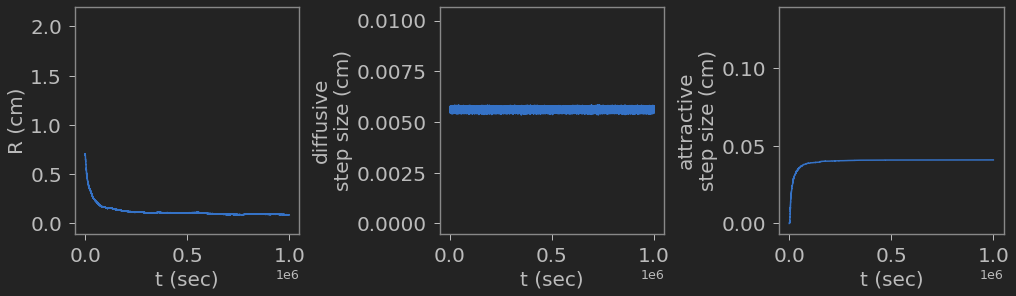

In [28]:
ylabel_lst=['R (cm)','diffusive\nstep size (cm)','attractive\nstep size (cm)']
fig,axs=plt.subplots(1,3,figsize=(14,4),constrained_layout=True)
for i,(ax,ylabel) in enumerate(zip(axs,ylabel_lst)):
    ax.plot(mean_array[:,i])
    ax.fill_between(mean_array[:,i]-1.96*std_array[:,i],mean_array[:,i]+1.96*std_array[:,i],alpha=0.5)
    format_plot(ax=ax,xlabel='t (sec)',ylabel=ylabel)
plt.show()

In [30]:
#TODO: compute the apparent attraction coefficient without smoothing

In [33]:
position_array.shape

(1000000, 4, 1500)

In [1]:
#TODO: for each pair, identify the last row where the value is not nan
row_end_values=zero_values.copy()
for i in range(num_pairs):
    row_end_values[i]=np.int(np.argwhere(np.isnan(position_array[:,0,i]))[0,0])-1

NameError: name 'zero_values' is not defined